### Simulations for the mean

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import scipy.sparse as sparse
import itertools
import numpy as np
import scipy.stats as stats
from scipy.special import kl_div
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time

In [255]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)


In [256]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento
import memento.simulate as simulate

In [257]:
data_path = '/home/ubuntu/Data/'

In [258]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
%autoreload 2

### Extract parameters from interferon dataset

In [260]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell_type == 'CD4 T cells - ctrl']
data = adata.X.copy()
relative_data = data.toarray()/data.sum(axis=1)

/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [304]:
q = 0.07
x_param, z_param, Nc, good_idx = memento.simulate.extract_parameters(adata.X, q=0.07, min_mean=0.001)

### Implementing Good estimator

In [353]:
n_cells=10
n_genes = x_param[0].shape[0]

In [374]:
true_data = memento.simulate.simulate_transcriptomes(n_cells=n_cells, means=z_param[0], variances=z_param[1], Nc=Nc, norm_cov='uncorrelated')
qs, captured_data = memento.simulate.capture_sampling(true_data, 0.05, None)
captured_data = captured_data[captured_data.sum(axis=1) > 0, :]
naive_m = (captured_data/captured_data.sum(axis=1).reshape(-1,1)).mean(axis=0)
pb_m = captured_data.sum(axis=0)/captured_data.sum()

In [375]:
def bincount2d(arr, bins=None):
    if bins is None:
        bins = np.max(arr) + 1
    count = np.zeros(shape=[len(arr), bins], dtype=np.int64)
    indexing = (np.ones_like(arr).T * np.arange(len(arr))).T
    np.add.at(count, (indexing, arr), 1)

    return count

def bincount2d_sparse(sparse_arr, bins=None):

    bins = np.round(sparse_arr.max()).astype(int) + 1
    num_cells, num_genes = sparse_arr.shape
    count = sparse.lil_matrix((num_cells, bins))
    for cell in range(num_cells):
        cell_counts = np.bincount(np.round(sparse_arr[cell].data).astype(int))
        cell_counts[0] = num_genes - sparse_arr[cell].nnz
        count[cell, np.arange(cell_counts.shape[0])] = cell_counts
    return count

def concordance(x, y, log=True):
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [376]:
captured_data = sparse.csr_matrix(captured_data)

### Investigate the Good estimator

In [377]:
# # Single cell Good estimator

# size_factor = captured_data.sum(axis=1).A1
# freqs = bincount2d_sparse(captured_data).toarray()
# expected_freqs = freqs[0]#freqs.mean(axis=0)

# max_val = freqs.shape[1]
# r = np.arange(max_val)

# r_star = (r[:5]+1).reshape(1,-1)*freqs[:, 1:6]/freqs[:, :5]

# dense_data = captured_data.toarray()

# for v in range(5):
#     row, col = np.where(dense_data==v)
#     dense_data[row, col] = r_star[row, v]
    
# sc_good_m = (dense_data/size_factor.reshape(-1,1)).mean(axis=0)

In [378]:

pb = captured_data.sum(axis=0).A1.astype(int)

pb_freqs = pd.Series(pb).value_counts().sort_index()

r = pb_freqs.index.values
nr = pb_freqs.values

z = pd.Series(pb_freqs.index).rolling(window=3, center=True).apply(lambda x: x.iloc[-1]-x.iloc[0]).values
z[0] = 2
z[-1] = z[-2]
z = 2*nr/z

r_star = (r+1)*np.concatenate([z[1:], z[-1:]])/z

pb_star = pb.copy().astype(float)
for r_val in r[r < 5]:#r[(r > 0) & (r < 50)]:
    
    pb_star[pb == r_val] = r_star[np.where(r==r_val)[0]][0]
good_m = pb_star/pb.sum()


### Investigate shrinkage towards pseudobulk proportions

In [379]:
pb = captured_data.sum(axis=0).A1
pb_proportions = pb/pb.sum()

In [380]:
dense_data = captured_data.toarray()

In [381]:
size_factor = captured_data.sum(axis=1).A1
#

In [382]:
expected_relative_data = size_factor.reshape(-1,1)*pb_proportions

In [383]:
expected_relative_data.shape

(10, 10805)

In [384]:
relative_dense_data = dense_data/dense_data.sum(axis=1).reshape(-1,1)

In [385]:
shrink_m = (((expected_relative_data+dense_data)/2)/dense_data.sum(axis=1).reshape(-1,1)).mean(axis=0)

In [386]:
# alpha = 0.2

In [387]:
# shrink_m = (alpha*relative_dense_data + (1-alpha)*pb_proportions).mean(axis=0)

### Some sanity checks

In [388]:
sc_good_m = np.zeros(true_data.shape[1])
pb_m2 = np.zeros(true_data.shape[1])
for cell_idx in range(true_data.shape[0]):

    z_cell = true_data[cell_idx]
    y = captured_data[cell_idx].todense().A1

    og_proportions = z_cell/z_cell.sum()
    mle_proportions = y/y.sum()

    pb = y

    pb_freqs = pd.Series(pb).value_counts().sort_index()

    r = pb_freqs.index.values
    nr = pb_freqs.values

    z = pd.Series(pb_freqs.index).rolling(window=3, center=True).apply(lambda x: x.iloc[-1]-x.iloc[0]).values
    z[0] = 2
    z[-1] = z[-2]
    z = 2*nr/z

    r_star = (r+1)*np.concatenate([z[1:], z[-1:]])/z

    pb_star = pb.copy().astype(float)
    for r_val in r[1:3]:

        pb_star[pb == r_val] = r_star[np.where(r==r_val)[0]][0]
    good_proportions = pb_star/pb.sum()
    
    sc_good_m += pb_star
    pb_m2 += pb
    
    # print('good', stats.wasserstein_distance(good_proportions, og_proportions))
    # print('MLE', stats.wasserstein_distance(mle_proportions, og_proportions))
    
    # break
        
pb_m2 /= captured_data.sum()
sc_good_m /= captured_data.sum()

In [389]:
# sc_good_m = memento.estimator._good_mean_only(captured_data, n_cells, 0.1, captured_data.sum(axis=1).A1, max_to_replace=3)[0]

### Measure concordances

In [390]:
true_m = z_param[0]/z_param[0].sum()

In [391]:
condition = true_m  > -1#10**-4.5

In [392]:
print(concordance(naive_m[condition], true_m[condition]))


0.4868235421850028


/tmp/ipykernel_1373/3568184144.py:24: RuntimeWarning: divide by zero encountered in log
  a = np.log(x)


In [393]:
# print(concordance(naive_m[condition], true_m[condition]))
# print(concordance(shrink_m[condition], true_m[condition]))
print(concordance(pb_m[condition], true_m[condition]))
print(concordance((true_data/true_data.sum(axis=1).reshape(-1,1)).mean(axis=0)[condition], true_m[condition]))

# print(concordance(sc_good_m[condition], true_m[condition]))
# print(concordance(good_m[condition], true_m[condition]))

# print('---')
# print(stats.wasserstein_distance(naive_m[condition], true_m[condition]))
# print(stats.wasserstein_distance(shrink_m[condition], true_m[condition]))
# print(stats.wasserstein_distance(pb_m[condition], true_m[condition]))
# print(stats.wasserstein_distance(sc_good_m[condition], true_m[condition]))
# print(stats.wasserstein_distance(good_m[condition], true_m[condition]))

0.4866286867482849
0.8414087124017625


/tmp/ipykernel_1373/3568184144.py:24: RuntimeWarning: divide by zero encountered in log
  a = np.log(x)


this underestimates the true mean


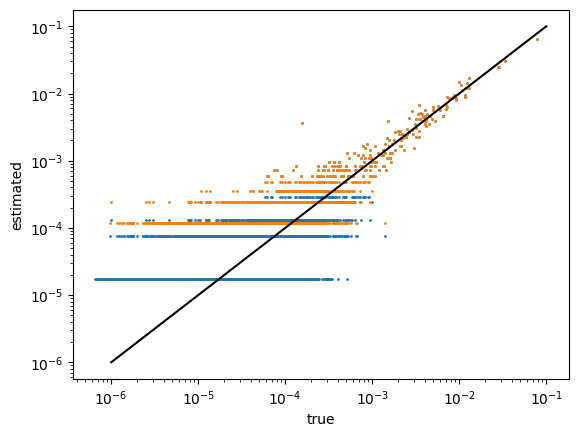

In [394]:
# plt.scatter(z_param[0]/z_param[0].sum(), naive_m, s=0.5)
plt.scatter(z_param[0]/z_param[0].sum(), good_m, s=1)

plt.scatter(z_param[0]/z_param[0].sum(), pb_m, s=1)



plt.yscale('log')
plt.xscale('log')
plt.xlabel('true');
plt.ylabel('estimated')
plt.plot([10**-6, 0.1],[10**-6, 0.1], color='k')
print('this underestimates the true mean')

### Some sanity checks

In [507]:
num_trials = 100
q = 0.000005
means = np.zeros(num_trials)
for trial in range(num_trials):
    
    data = stats.poisson.rvs(2, size=1000000)
    captured_data = stats.binom.rvs(data, q)
    means[trial] = captured_data.mean()

In [508]:
print(10*q)

5e-05


In [509]:
np.mean(means)

9.98e-06

(array([51.,  0.,  0., 39.,  0.,  0.,  9.,  0.,  0.,  1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

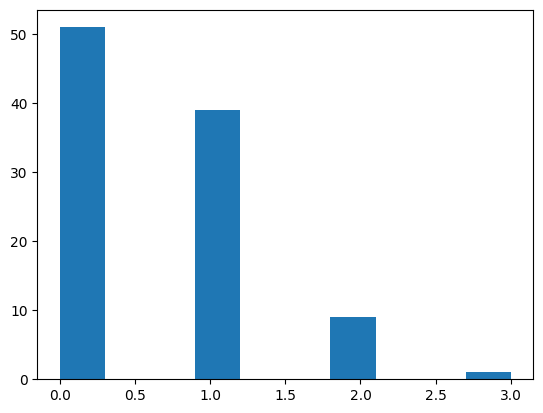

In [397]:
plt.hist(captured_data)

In [235]:
x = stats.uniform.rvs(0, 10, size=(5000, 1000)).astype(int)

In [236]:
q1 = 0.5
q2 = 0.1

y1 = simulate.capture_sampling(x, q=q1)[1]
y2 = simulate.capture_sampling(x, q=q2)[1]

In [245]:
from sklearn.decomposition import PCA

In [246]:
model = PCA(n_components=2)
model.fit(np.vstack([naive_mean(x), naive_mean(y1)]).T)

PCA(n_components=2)

In [248]:
model.components_

array([[-0.61036689, -0.79211885],
       [-0.79211885,  0.61036689]])

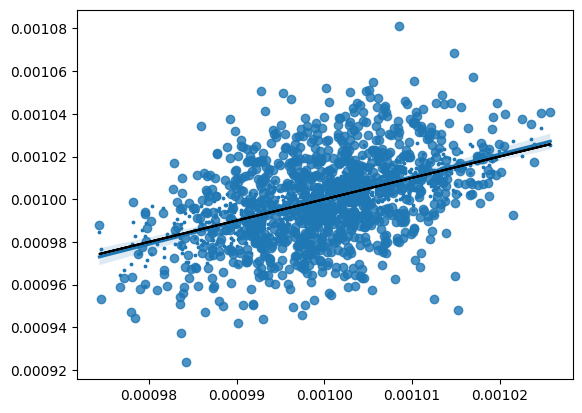

In [244]:
plt.scatter(naive_mean(x), naive_mean(y1), s=3)
sns.regplot(x=naive_mean(x), y=naive_mean(y2))

plt.plot(naive_mean(x), naive_mean(x), color='k')


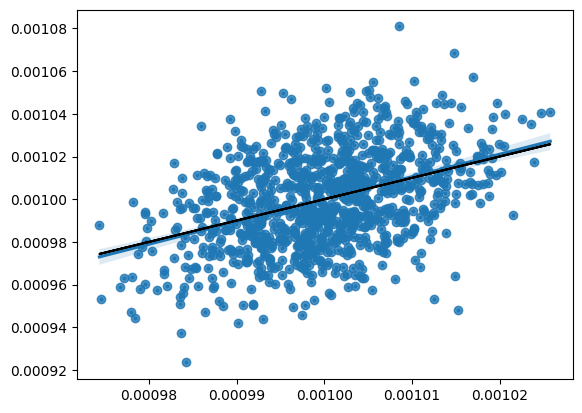

In [243]:
plt.scatter(naive_mean(x), naive_mean(y2), s=3)
sns.regplot(x=naive_mean(x), y=naive_mean(y2))
plt.plot(naive_mean(x), naive_mean(x), color='k')

In [197]:
y.mean(axis=0)

array([0.429, 0.466, 0.488, 0.439, 0.41 , 0.44 , 0.423, 0.477, 0.441,
       0.487])

In [198]:
x.mean(axis=0)

array([4.275, 4.243, 4.611, 4.551, 4.371, 4.54 , 4.602, 4.583, 4.483,
       4.714])

In [240]:
better

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Implement the good estimator

In [101]:

arr = captured_data
size_factor = arr.sum(axis=1).A1

pb = (arr.sum(axis=0).A1+1)
alpha=0.9
max_to_replace = 10
total_umi = pb.sum()
denom = np.array([total_umi - pb[sparse.find(arr[i])[1]].sum() for i in range(n_cells)]).mean()


freqs = bincount2d_sparse(arr)
expected_freqs = freqs#.mean(axis=0).A1

initial_values = np.tile(np.arange(max_to_replace)[:,np.newaxis], (1,n_genes))
final_values = (initial_values + 1) * expected_freqs[initial_values+1] / expected_freqs[initial_values]
final_values[0] = (0+1) * expected_freqs[1] * (alpha*(pb/denom) + ((1-alpha)/expected_freqs[0]))

corrected_counts = sparse.csr_matrix(arr, dtype=float)
for val in range(1,max_to_replace):
    corrected_counts.data[corrected_counts.data == val] = final_values[val, 0]
    
corrected_counts = sparse.diags(1/size_factor) @ corrected_counts # normalize for size_factor
nonzero_sum = corrected_counts.sum(axis=0).A1
num_zeros_per_column = arr.shape[0] - arr.getnnz(axis=0)
zero_sum = np.array([(final_values[0, idx]/size_factor[~np.in1d(range(size_factor.shape[0]), sparse.find(arr[:, idx])[0])]).sum() for idx in range(n_genes)])
m = (nonzero_sum + zero_sum)/arr.shape[0]

In [ ]:
plt.scatter(x_param[0], np.log10(m), s=5)

In [51]:
m

array([9.08805869e-05, 2.75634520e-04, 1.10201243e-04, ...,
       2.64625514e-04, 9.27884306e-05, 2.71518244e-04])

In [16]:
arr = captured_data
pb = (arr.sum(axis=0).A1+1)
alpha=0.9


smooth_arr = arr.copy().astype(np.float64)
freqs = bincount2d_sparse(arr)
expected_freqs = freqs.mean(axis=0).A1

smooth_mask = (arr < 10)
smooth_arr[smooth_mask] = (arr[smooth_mask].A1+1)*expected_freqs[arr[smooth_mask].A1+1] / expected_freqs[arr[smooth_mask].A1]

smooth_mask = (arr == 0)
denom = np.array([pb[sparse.find(smooth_mask[i])[1]].sum() for i in range(n_cells)]).mean()

rows, cols, _ = sparse.find(smooth_mask)
smooth_arr[rows, cols] = expected_freqs[1]*(alpha*(pb[cols]/denom) + ((1-alpha)/expected_freqs[0]))
m = (smooth_arr/arr.sum(axis=1).A1[:, np.newaxis]).mean(axis=0).A1

/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


### put in in a function

In [52]:
def _mean_only_shrink(data, n_obs, q, size_factor=None, alpha=0.9):
    """
        Hypergeometric mean estimator based on Good's estimator.
    """

    if type(data) == tuple:
        return
    else:
        
    
        smooth_arr = data.copy().astype(np.float64)
        freqs = bincount2d_sparse(data)
        expected_freqs = freqs.mean(axis=0).A1

        smooth_mask = (data < 10)
        smooth_arr[smooth_mask] = (data[smooth_mask].A1+1)*expected_freqs[data[smooth_mask].A1+1] / expected_freqs[data[smooth_mask].A1]

        smooth_mask = (data == 0)
        pb = (arr.sum(axis=0).A1+1)

        denom = np.array([pb[sparse.find(smooth_mask[i])[1]].sum() for i in range(n_obs)]).mean()

        rows, cols, _ = sparse.find(smooth_mask)
        smooth_arr[rows, cols] = expected_freqs[1]*(alpha*(pb[cols]/denom) + ((1-alpha)/expected_freqs[0]))
        m = (smooth_arr/size_factor[:, np.newaxis]).mean(axis=0).A1

        return m, np.ones(m.shape)

In [53]:
m, v = _mean_only_shrink(captured_data, n_obs=n_cells, q=q, size_factor=captured_data.sum(axis=1).A1)

/Users/mincheolkim/opt/miniconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  """Entry point for launching an IPython kernel.


In [54]:
data

<5142x35635 sparse matrix of type '<class 'numpy.float32'>'
	with 2568577 stored elements in Compressed Sparse Row format>

In [55]:
m

array([9.08805869e-05, 2.75634520e-04, 1.10201243e-04, ...,
       2.64625514e-04, 9.27884306e-05, 2.71518244e-04])

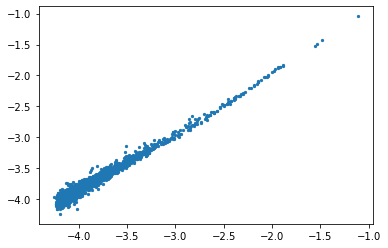

In [20]:
plt.scatter(np.log10(x_param[0]), np.log10(m), s=5)

### Try it out in the full memento codebase

In [27]:
%load_ext autoreload

In [35]:
%autoreload 2

In [58]:
adata.obs['q'] = 0.07

In [61]:
memento.setup_memento(adata, q_column='q')

In [68]:
memento.create_groups(adata, label_columns=['cell'])

In [69]:
memento.compute_1d_moments(adata)

In [76]:
adata.uns['memento']['1d_moments']['sg^CD4 T cells'][0]

[array([7.0354872e-05, 2.0055490e-04, 7.0600538e-05, ..., 1.9567333e-04,
        7.1403862e-05, 2.1235883e-04], dtype=float32),
 array([9.3322754e-09, 9.5357666e-07, 5.0630437e-08, ..., 3.0482820e-08,
        7.4649424e-09, 5.4613079e-08], dtype=float32),
 array([ 0.67086899, 19.38791847,  3.62503791, ...,  0.6392253 ,
         0.52752513,  1.03328931])]

In [ ]:

def _mean_only_shrink(data, n_obs, q, size_factor=None, alpha=0.9):
    """
        Hypergeometric mean estimator based on Good's estimator.
    """

    if type(data) == tuple:
        return
    else:
        
    
        smooth_arr = data.copy().astype(np.float64)
        freqs = bincount2d_sparse(data)
        expected_freqs = freqs.mean(axis=0).A1

        smooth_mask = (data < 10)
        smooth_arr[smooth_mask] = (data[smooth_mask].A1+1)*expected_freqs[data[smooth_mask].A1+1] / expected_freqs[data[smooth_mask].A1]

        smooth_mask = (data == 0)
        pb = (arr.sum(axis=0).A1+1)

        denom = np.array([pb[sparse.find(smooth_mask[i])[1]].sum() for i in range(n_obs)]).mean()

        rows, cols, _ = sparse.find(smooth_mask)
        smooth_arr[rows, cols] = expected_freqs[1]*(alpha*(pb[cols]/denom) + ((1-alpha)/expected_freqs[0]))
        m = (smooth_arr/size_factor[:, np.newaxis]).mean(axis=0).A1

        return m, np.ones(m.shape)